In [0]:
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import time
import os
import json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = [4, 4] #width then height

In [0]:
#------------------------------------------------------------------------------
# We slightly altered the download function to allow using different datasets
#------------------------------------------------------------------------------

def download(data="mnist_784"):
    mnist = fetch_openml(data)
    X = mnist.data.astype("float64")
    y = mnist.target
    print (data,":", X.shape, y.shape)
    if data=="mnist_784" :
        download.trainset_size = 60000
    elif data =="artificial-characters":
        download.trainset_size = 8500 #artifical-characters has +-10000 instances
    elif data=="gas-drift":
        download.trainset_size = 12000 #artifical-characters has +-14000 instances
    return (X, y)

def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)

In [0]:
#------------------------------------------------------------------------------
# we added a KNNModel class to the class BaseModel.
#------------------------------------------------------------------------------

class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)
    
class KNNModel(BaseModel):
    
    model_type = "K-Nearest Neighbors"
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training k-nearest neigbors...')
        self.classifier = KNeighborsClassifier(n_neighbors=9)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [0]:
#------------------------------------------------------------------------------
# We added a list for the F1-score to the TrainModel object
# and implemented the metric in the "get_test_accuracy" function
#------------------------------------------------------------------------------
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.f1s = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        classif_rate2 = metrics.f1_score(y_test, self.test_y_predicted, average='weighted' )
        self.accuracies.append(classif_rate)  
        self.f1s.append(classif_rate2)
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))  
        print("Weighted F1-score for %f " % (classif_rate2))  
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')

In [0]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection

      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [0]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

In [0]:
#------------------------------------------------------------------------------
# We altered the TheAlgorithm class by printing the final f1-scores
#------------------------------------------------------------------------------

class TheAlgorithm(object):

    accuracies = []
    f1s = []
    
    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)     
            
            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

            print ('final active learning accuracies',
               self.clf_model.accuracies)
            print ('final active learning f1-scores',
               self.clf_model.f1s)

In [20]:
(X, y) = download()
trainset_size = download.trainset_size

(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
    filehandler = open(fname,"wb")
    pickle.dump(data,filehandler)
    filehandler.close() 
    print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
    print(os.getcwd(), os.listdir())
    file = open(fname,'rb')
    data = pickle.load(file)
    file.close()
    print(data)
    return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
        if model_object.__name__ not in d:
            d[model_object.__name__] = {}
      
        for selection_function in selection_functions:
            if selection_function.__name__ not in d[model_object.__name__]:
                d[model_object.__name__][selection_function.__name__] = {}
        
            for k in Ks:
                d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
                for i in range(0, repeats):
                    count+=1
                    if count >= contfrom:
                        print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                        alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                        alg.run(X_train_full, y_train_full, X_test, y_test)
                        d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                        d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.f1s)
                        fname = 'Active-learning-experiment-MNIST-' + str(count) + '.pkl'
                        pickle_save(fname, d)
                        if count % 5 == 0:
                            print(json.dumps(d, indent=2, sort_keys=True))
                        print ()
                        print ('---------------------------- FINISHED ---------------------------')
                        print ()
    return d


max_queried = 500 
repeats = 1
models = [KNNModel, SvmModel, RfModel] 
selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 
Ks = [250,125,50,25,10] 
d = {}
stopped_at = 45

#print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
d = pickle_load('Active-learning-MNIST-experiment-' + str(stopped_at) + '.pkl')  
#print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
#print(results)

mnist_784 : (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
/content ['.config', 'Active-learning-GD-experiment-45.pkl', 'Active-learning-MNIST-experiment-45.pkl', 'sample_data']
{'KNNModel': {'RandomSelection': {'250': [[75.33999999999999, 82.33], [0.7526828993838699, 0.822948798836791]], '125': [[66.25, 75.26, 78.83, 81.63], [0.6544546190520524, 0.7495938639160493, 0.7859202732642152, 0.8151102686463045]], '50': [[47.77, 59.31999999999999, 66.10000000000001, 69.69, 73.42, 77.88000000000001, 79.08, 81.01, 82.08, 82.8], [0.40412205213925817, 0.5624739063336919, 0.6302724409630449, 0.6843391189225193, 0.7284026596284194, 0.7778576599114141, 0.7893628071074283, 0.8093499616798178, 0.81959221251285, 0.8266344099452068]], '25': [[33.45, 40.89, 49.24, 51.349999999999994, 55.45, 59.64, 60.550000000000004, 62.419999999999995, 65.48, 68.75, 70.78, 72.83, 74.14, 75.32, 77.08, 78.02, 79.13, 79.4, 79.97999999999999, 80.60000000000001], [0.25986712

In [0]:
#------------------------------------------------------------------------------
# Calculating the upperbounds on MNIST 
#------------------------------------------------------------------------------

(X, y) = download()
trainset_size = download.trainset_size
(X_train, y_train, X_test, y_test) = split(trainset_size)

X_val_dummy = np.zeros(shape=X_test.shape)
normalizer = Normalize()
X_train, _, X_test = normalizer.normalize(X_train, X_val_dummy, X_test)   

c_weight ='balanced'
svc = SVC(C=1, kernel='linear', probability=True,class_weight=c_weight)
randf = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
knn = KNeighborsClassifier(n_neighbors=9)

acc = []
f1s = []
for model in [knn, svc, randf]:
    print(model)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    
    acc.append(metrics.accuracy_score(y_test, y_pred))
    f1s.append(metrics.f1_score(y_test, y_pred, average='weighted'))
    
print(acc)
print(f1s)

mnist_784 : (70000, 784) (70000,)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
#------------------------------------------------------------------------------
# Calculating upperbounds on Gas Drift dataset
#------------------------------------------------------------------------------

(X, y) = download("gas-drift")
trainset_size = download.trainset_size
(X_train, y_train, X_test, y_test) = split(trainset_size)

X_val_dummy = np.zeros(shape=X_test.shape)
normalizer = Normalize()
X_train, _, X_test = normalizer.normalize(X_train, X_val_dummy, X_test)   

c_weight ='balanced'
svc = SVC(C=1, kernel='linear', probability=True,class_weight=c_weight)
randf = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
knn = KNeighborsClassifier(n_neighbors=9)

acc = []
f1s = []
for model in [knn, svc, randf]:
    print(model)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    
    acc.append(metrics.accuracy_score(y_test, y_pred))
    f1s.append(metrics.f1_score(y_test, y_pred, average='weighted'))
    
print(acc)
print(f1s)

In [19]:
#------------------------------------------------------------------------------
# Running active learning algorithm on Gas Drift data
#------------------------------------------------------------------------------

(X, y) = download("gas-drift")
trainset_size = download.trainset_size

(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def experiment2(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
        if model_object.__name__ not in d:
            d[model_object.__name__] = {}
      
        for selection_function in selection_functions:
            if selection_function.__name__ not in d[model_object.__name__]:
                d[model_object.__name__][selection_function.__name__] = {}
        
            for k in Ks:
                d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
                for i in range(0, repeats):
                    count+=1
                    if count >= contfrom:
                        print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                        alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                        alg.run(X_train_full, y_train_full, X_test, y_test)
                        d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                        d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.f1s)
                        fname = 'Active-learning-experiment-GD-' + str(count) + '.pkl'
                        pickle_save(fname, d)
                        if count % 5 == 0:
                            print(json.dumps(d, indent=2, sort_keys=True))
                        print ()
                        print ('---------------------------- FINISHED ---------------------------')
                        print ()
    return d


max_queried = 500 
repeats = 1
models = [KNNModel, SvmModel, RfModel] 
selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 
Ks = [250,125,50,25,10] 
d = {}
stopped_at = 45

#print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
d = pickle_load('Active-learning-GD-experiment-' + str(stopped_at) + '.pkl')  
#print(json.dumps(d, indent=2, sort_keys=True))

d = experiment2(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
#print(results)

gas-drift : (13910, 128) (13910,)
train: (12000, 128) (12000,)
test : (1910, 128) (1910,)
unique classes 6
/content ['.config', 'Active-learning-GD-experiment-45.pkl', 'Active-learning-MNIST-experiment-45.pkl', 'sample_data']
{'KNNModel': {'RandomSelection': {'250': [[66.59685863874346, 70.36649214659685], [0.6193428843914085, 0.6924467511061996]], '125': [[41.93717277486911, 56.12565445026178, 65.39267015706807, 71.72774869109948], [0.42375561747885904, 0.5956991996906918, 0.674157440701053, 0.7263282645624506]], '50': [[40.99476439790576, 43.87434554973822, 57.27748691099477, 55.811518324607334, 55.130890052356015, 57.48691099476439, 58.06282722513089, 60.47120418848168, 64.86910994764398, 65.60209424083769], [0.38267073849855116, 0.47190456718710067, 0.590788134500159, 0.5770651651565578, 0.5789507888729651, 0.600102799074511, 0.6111717313650994, 0.6356386642936135, 0.6689805187352325, 0.672229068020249]], '25': [[19.10994764397906, 34.345549738219894, 30.89005235602094, 51.36125654

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


IndexError: ignored

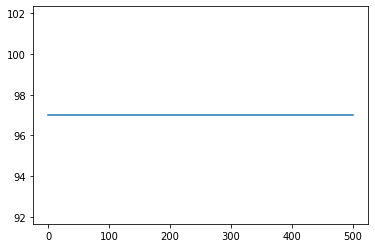

In [27]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
        for selection_function in selection_functions:
            for idx, k in enumerate(Ks):
                x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
                Sum = np.array(dic[model_object][selection_function][k][0])
                for i in range(1, repeats):
                    Sum = Sum + np.array(dic[model_object][selection_function][k][i])
                mean = Sum / repeats
                ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['SvmModel', 'RfModel', 'KNNModel'] 
selection_functions_str = ['RandomSelection',  'EntropySelection','MarginSamplingSelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
random_forest_upper_bound = 97.
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str, Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(log_upper_bound, d, ['KNNModel'] , selection_functions_str    , Ks_str, 1)

So which is the best sample selection function? margin sampling is the winner!


KeyError: ignored

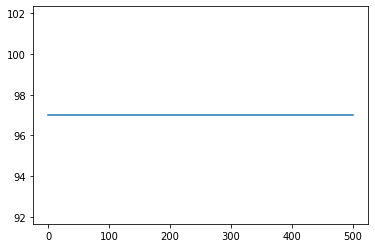

In [0]:
print('So which is the best sample selection function? margin sampling is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'], selection_functions_str    , Ks_str, 1)
print()
print('So which is the best k? k=10 is the winner')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)